# Install Transformers Library

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [5]:
df = pd.read_csv("cleaned_news_dataset.csv")
df.head()

,text,label
0,st century wire says ben stein reputable prof...,0
1,washington reuters u s president donald t...,1
2,reuters puerto rico governor ricardo rossel...,1
3,on monday donald trump once again embarrassed...,0
4,glasgow scotland reuters most u s presid...,1


In [6]:
df = df.sample(frac=1.0)

In [7]:
df.shape

(44183, 2)

In [8]:
# check class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.515289
1,0.484711


# Split train dataset into train, validation and test sets

In [9]:
# Drop rows with missing values in the 'label' column
df.dropna(subset=['label'], inplace=True)

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.4,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [10]:
test_text

,text
32517,when looking at any donald trump event lately ...
2142,washington reuters democrats on the u s s...
25855,this is priceless the video below shows just ...
36191,maine state representative scott hamann d is...
40610,brussels reuters britain and the european ...
...,...
2508,washington reuters the united states will ...
43449,a tennessee man did what thousands of ammosexu...
20198,keep in mind a group funded by one of hillary...
1880,dubai reuters saudi arabia s king salman r...


In [11]:
print(type(test_text))
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [12]:
print(f"Number of training samples: {len(train_text)}")
print(f"Number of validation samples: {len(val_text)}")
print(f"Number of test samples: {len(test_text)}")

Number of training samples: 26509
Number of validation samples: 8837
Number of test samples: 8837


# Import BERT Model and BERT Tokenizer

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [15]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization and Augmentation

<Axes: >

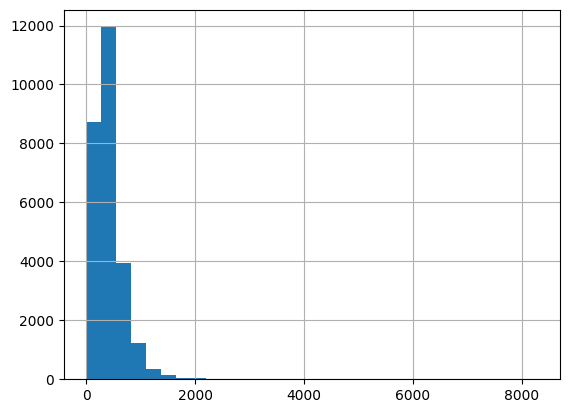

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [17]:
max_seq_len = 128

In [18]:
import random
# Augmentation function
def augment_dataset(texts, labels, augmentations_per_sample=2, mask_prob=0.15):
    """Augment entire dataset"""
    aug_texts = []
    aug_labels = []

    for text, label in zip(texts, labels):
        # Add original
        aug_texts.append(text)
        aug_labels.append(label)

        # Add augmented versions
        for _ in range(augmentations_per_sample):
            words = text.split()
            masked = [w if random.random() > mask_prob else '[MASK]'
                     for w in words]
            aug_texts.append(' '.join(masked))
            aug_labels.append(label)

    return aug_texts, aug_labels

# AUGMENT TRAINING DATA
augmented_train_text, augmented_train_labels = augment_dataset(
    train_text.tolist(),
    train_labels.tolist(),
    augmentations_per_sample=2,
    mask_prob=0.15
)

print(f"Original: {len(train_text)} → Augmented: {len(augmented_train_text)}")

# TOKENIZE AUGMENTED DATA
tokens_train = tokenizer.batch_encode_plus(
    augmented_train_text,
    max_length=max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# TOKENIZE VALIDATION (no augmentation)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# TOKENIZE TEST (no augmentation)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

Original: 26509 → Augmented: 79527


# Convert Integer Sequences to Tensors

In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [20]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, torch.tensor(augmented_train_labels))

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [22]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
# from transformers.optimization import AdamW
import torch.optim as optim

# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.97031479 1.03155888]


In [26]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
nll_loss  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 5

# Fine-Tune BERT

In [27]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = nll_loss(preds, labels.long()) # Cast labels to long

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [28]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = nll_loss(preds,labels.long()) # Cast labels to long

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [29]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 5
  Batch    50  of  2,486.
  Batch   100  of  2,486.
  Batch   150  of  2,486.
  Batch   200  of  2,486.
  Batch   250  of  2,486.
  Batch   300  of  2,486.
  Batch   350  of  2,486.
  Batch   400  of  2,486.
  Batch   450  of  2,486.
  Batch   500  of  2,486.
  Batch   550  of  2,486.
  Batch   600  of  2,486.
  Batch   650  of  2,486.
  Batch   700  of  2,486.
  Batch   750  of  2,486.
  Batch   800  of  2,486.
  Batch   850  of  2,486.
  Batch   900  of  2,486.
  Batch   950  of  2,486.
  Batch 1,000  of  2,486.
  Batch 1,050  of  2,486.
  Batch 1,100  of  2,486.
  Batch 1,150  of  2,486.
  Batch 1,200  of  2,486.
  Batch 1,250  of  2,486.
  Batch 1,300  of  2,486.
  Batch 1,350  of  2,486.
  Batch 1,400  of  2,486.
  Batch 1,450  of  2,486.
  Batch 1,500  of  2,486.
  Batch 1,550  of  2,486.
  Batch 1,600  of  2,486.
  Batch 1,650  of  2,486.
  Batch 1,700  of  2,486.
  Batch 1,750  of  2,486.
  Batch 1,800  of  2,486.
  Batch 1,850  of  2,486.
  Batch 1,900  of  2,486

In [30]:
import matplotlib.pyplot as plt

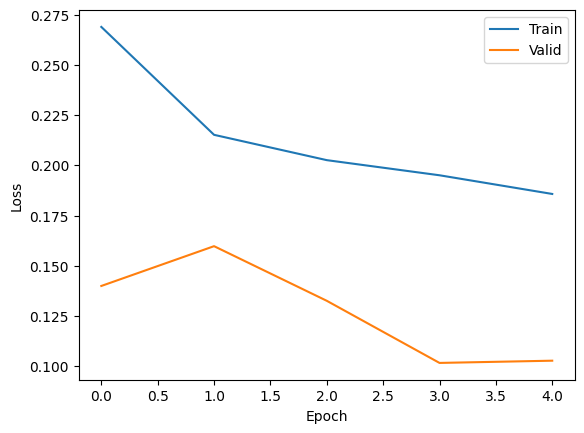

In [31]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load Saved Model and Making Predictions

In [32]:
!pip install azureml-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.8/308.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.0/614.0 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3

In [33]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
import torch.optim as optim # Import AdamW from torch.optim
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
# from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig # Remove incorrect import
from transformers import DistilBertForSequenceClassification, DistilBertConfig # Keep correct imports
# from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
from azureml.core import Workspace, Run, Dataset
from azureml.core.model import Model
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('saved_weights.pt'))

<All keys matched successfully>

In [ ]:
# df = pd.read_csv('shorttextpreprocessedtest.csv')
# df.dropna(inplace=True)
# # print(df.head())

# test_text = df.text
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# max_seq_len = 25

# # tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])

# with torch.no_grad():
#   pred_proba = test_model(test_seq.to(device), test_mask.to(device))
#   pred_proba = pred_proba.detach().cpu().numpy()

# preds = np.argmax(pred_proba, axis = 1)

# print([preds.tolist(), pred_proba.tolist()])

In [34]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from sklearn.metrics import precision_score, recall_score, f1_score

# Use your already-split test data:
test_text = test_text  # Already exists from your split!
test_y = test_labels   # Already exists from your split!

# Tokenize
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

# Create a DataLoader for the test set to process in batches
test_data = TensorDataset(test_seq, test_mask, torch.tensor(test_y.tolist()))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Get predictions in batches
model.eval() # Set model to evaluation mode
total_preds = []
with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        preds_batch = test_model(sent_id, mask)
        total_preds.append(preds_batch.detach().cpu().numpy())

# Concatenate predictions from all batches
preds = np.concatenate(total_preds, axis=0)

# Now you can evaluate properly with test_y
preds_class = np.argmax(preds, axis=1)
precision = precision_score(test_y, preds_class, average='weighted') # Changed to weighted for better handling of imbalanced classes
recall = recall_score(test_y, preds_class, average='weighted') # Changed to weighted
f1 = f1_score(test_y, preds_class, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9642257340071275
Recall: 0.9636754554713138
F1-Score: 0.963683935845316


# Get Predictions for Test Data

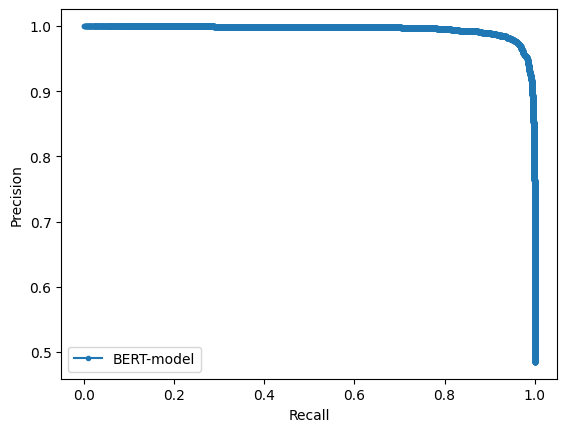


Matthews Corr Coef: 0.9388367147433491
Precision: 0.9682613768961493
Recall: 0.9687135185617558
f-1 score: 0.9694468554741809
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4554
           1       0.97      0.97      0.97      4283

    accuracy                           0.97      8837
   macro avg       0.97      0.97      0.97      8837
weighted avg       0.97      0.97      0.97      8837



In [ ]:
# get predictions for test data

# Create a DataLoader for the test set to process in batches
test_data = TensorDataset(test_seq, test_mask, torch.tensor(test_y.tolist()))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Get predictions in batches
test_model.eval() # Set model to evaluation mode
total_preds_output = [] # Renamed to avoid conflict with `preds` for metrics
with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch # labels not used here but for consistency

        preds_batch = test_model(sent_id, mask)
        total_preds_output.append(preds_batch.detach().cpu().numpy())

# Concatenate predictions from all batches
preds = np.concatenate(total_preds_output, axis=0)

# model's performance
precision_, recall_, proba = precision_recall_curve(test_y, preds[:, -1])
preds_class = np.argmax(preds, axis = 1) # Renamed to avoid overwriting `preds` which is needed for precision_recall_curve

#plot precision-recall curve
plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
# preds = [1 if i >= optimal_proba_cutoff else 0 for i in preds[:, -1]]

mcc = matthews_corrcoef(test_y, preds_class)
tn, fp, fn, tp = confusion_matrix(test_y, preds_class).ravel()
precision = precision_score(test_y, preds_class)
recall = recall_score(test_y, preds_class)
f1 = f1_score(test_y, preds_class, average='weighted')

print("")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)

print(classification_report(test_y, preds_class))


In [ ]:
import pandas as pd

results = pd.DataFrame({
    "text": test_text,   # Corrected variable name
    "true_label": test_y,
    "predicted_label": preds_class # Changed from preds to preds_class
})

# Show misclassified examples:
results[results.true_label != results.predicted_label].head(10)

,text,true_label,predicted_label
31006,london reuters under the gaze of a life si...,1,0
27377,but parent activists are suggesting trump is g...,0,1
27625,wuhan china reuters call them china s bub...,1,0
20249,colorado springs colo reuters the billio...,1,0
40119,reuters co host of msnbc’s “morning joe” an...,1,0
42485,the obama administration has done everything i...,0,1
8218,andrew korybko global village spacethe us dep...,0,1
24697,everglades city fla reuters as hurricane...,1,0
31859,washington reuters one of donald trump’s s...,1,0
20846,federal lawmakers are investigating how a form...,0,1


Confusion Matrix:
[[4418  136]
 [ 134 4149]]

Breakdown:
True Negatives (Correctly predicted Real): 4418
False Positives (Real predicted as Fake): 136
False Negatives (Fake predicted as Real): 134
True Positives (Correctly predicted Fake): 4149


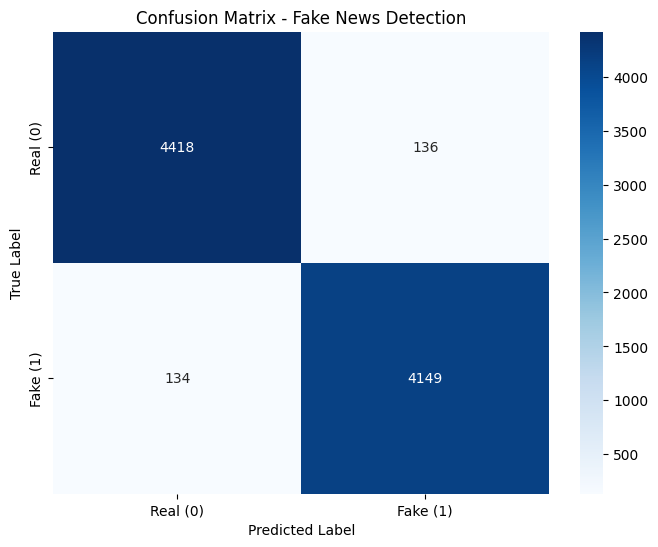

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_y, preds_class)

# Display as numbers
print("Confusion Matrix:")
print(cm)
print("\nBreakdown:")
print(f"True Negatives (Correctly predicted Real): {cm[0,0]}")
print(f"False Positives (Real predicted as Fake): {cm[0,1]}")
print(f"False Negatives (Fake predicted as Real): {cm[1,0]}")
print(f"True Positives (Correctly predicted Fake): {cm[1,1]}")

# Visualize with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()



Testing on Urdu data

In [35]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Load the Best Weights

try:
    path = 'saved_weights.pt'
    model.load_state_dict(torch.load(path))
    print("✅ Loaded best model weights from training.")
except Exception as e:
    print("⚠️ Could not load saved weights (using current model in memory).")

#Urdu Test Data
df_urdu = pd.read_csv("test.csv")
df_urdu = df_urdu[['text', 'label']].dropna()

# Tokenize Urdu Data (Using the existing 'tokenizer' from previous cells)
print(f"Tokenizing {len(df_urdu)} Urdu samples...")
tokens_urdu = tokenizer.batch_encode_plus(
    df_urdu['text'].tolist(),
    max_length = 128, # Or use your variable 'max_seq_len'
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# Convert to tensors
test_seq_ur = torch.tensor(tokens_urdu['input_ids'])
test_mask_ur = torch.tensor(tokens_urdu['attention_mask'])
test_y_ur = torch.tensor(df_urdu['label'].tolist())

# 4. Create DataLoader
test_data_ur = TensorDataset(test_seq_ur, test_mask_ur, test_y_ur)
test_sampler_ur = SequentialSampler(test_data_ur)
test_dataloader_ur = DataLoader(test_data_ur, sampler=test_sampler_ur, batch_size=32)

# 5. Get Predictions
print("Running predictions...")
model.eval()
preds_ur = []

with torch.no_grad():
    for batch in test_dataloader_ur:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        output = model(sent_id, mask)
        preds_ur.append(output.detach().cpu().numpy())

preds_ur = np.concatenate(preds_ur, axis=0)
preds_class_ur = np.argmax(preds_ur, axis=1)

# Show Results for Report
print("\n" + "="*40)
print("RESULTS: English Model on Urdu Data")
print("="*40)
print(f"Accuracy: {accuracy_score(test_y_ur, preds_class_ur):.4f}")
print("\nClassification Report:")
print(classification_report(test_y_ur, preds_class_ur, zero_division=0))



✅ Loaded best model weights from training.
Tokenizing 15682 Urdu samples...
Running predictions...

RESULTS: English Model on Urdu Data
Accuracy: 0.5173

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.94      0.64      7230
           1       0.75      0.16      0.26      8452

    accuracy                           0.52     15682
   macro avg       0.62      0.55      0.45     15682
weighted avg       0.63      0.52      0.44     15682



Confusion Matrix:
[[6776  454]
 [7115 1337]]

Breakdown:
True Negatives (Correctly predicted Real): 6776
False Positives (Real predicted as Fake): 454
False Negatives (Fake predicted as Real): 7115
True Positives (Correctly predicted Fake): 1337


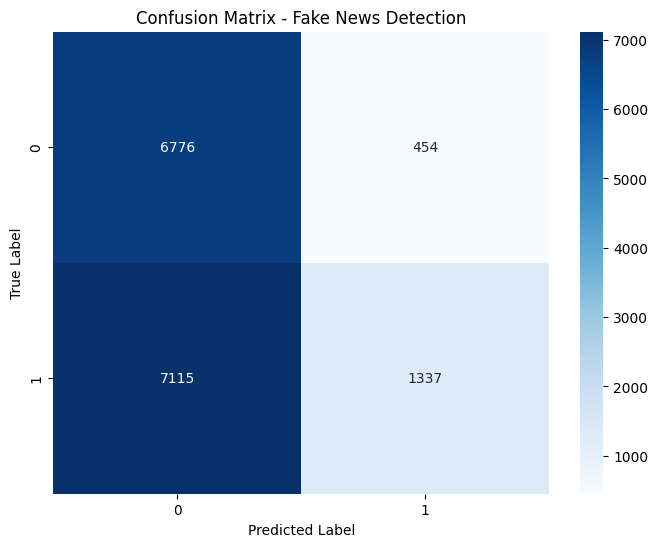

In [36]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_y_ur, preds_class_ur)

# Display as numbers
print("Confusion Matrix:")
print(cm)
print("\nBreakdown:")
print(f"True Negatives (Correctly predicted Real): {cm[0,0]}")
print(f"False Positives (Real predicted as Fake): {cm[0,1]}")
print(f"False Negatives (Fake predicted as Real): {cm[1,0]}")
print(f"True Positives (Correctly predicted Fake): {cm[1,1]}")

# Visualize with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1],
            yticklabels=[0, 1])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

